## Approximation of linear and non-linear ODE's through explicit methods.
-------
### Introduction and objective
Exact and analytic solutions are of great educational, academic, theoretical, comprehension and validation value, but their quantitative results for a given practical problem at hand are at best approximate due to an inevitable mismatch between ideal theory and observable reality. 

In practice, when quantitative results for a given real-world problem are required, the numerically approximate estimation may often be demonstrably better (more accurate, faster, comprehensive, correct, exhaustive, efficient, cost-effective, etc.) than the analytical.

Our aim will be to Implement two explicit solvers, the forward Euler and Ralston methods, to later study the convergence order and to compare the methods using a non-linear 2x2 ODE system.

In [28]:
# import the libraries needed for the hole assignment.
import numpy as np
from math import e
from matplotlib import pyplot as plt
from numpy import zeros, array, exp
from numpy.linalg import norm
import numpy as np

### Defining The Numerical schemes: Forward Euler Method and Ralston Method.

We will approximate the system of ODE's with this 2 numerical schemes.
Given initial data $y_0$ , $t_0$ and a the step size $h$ and the right hand side $f$ of an ODE the forward Euler Method computes:  $$y_{n+1} =y_n+hf(t_n,y_n)$$ where $y_n = y_0 +nh$. 

Similarly the Ralston Methods computes  $y_{n+1}$ the following way: $$ y_{n+1} = Φ(t_n, y_n; h) := y_n + \frac{h}{4}(f(t_n, y_n) + 3f(t_n +\frac{2h}{3}, y_n +\frac{2h}{3}f(t_n, y_n))$$
Note that Ralston's Method requires two evaluations of f at $(t_n, y_n)$, To optimize the number of calls to the function from 3 to 2 we store this values as a variable.



In [10]:
def forwardEuler( f,Df, t0,y0, h):
    return y0 + h*f(t0,y0)

def Ralston( f,Df, t0,y0, h):
    f0 = f(t0,y0)
    f1 = f(t0+2/3*h, y0 + 2/3*h*f0)
    return y0 + h/4*(f0+3*f1)

### Setting Up the ODE Problem

 Problem setup for ODE
 $y'(t)=F(y(t))$ and $y(0)=y_0$ with right hand side
 $$ F(y_1,y_2) = \left(\begin{array}{cc} y_2 \\[1ex] y_2(\lambda-2y_1) \end{array}\right) $$
 With $\lambda=1$ and initial conditions $y_0=(2, -2)^T$ this has the exact solution
 $$ Y(t) = \left(\begin{array}{cc}
      \frac{2e^t}{2e^t-1} \\[2ex]
      \frac{-2e^{t}}{4e^{2t}-4e^t+1}
 \end{array}\right) $$
We will solve this on the interval $[0,T]$.

In [11]:
T = 1
Y = lambda t: array([2*exp(t)/(2*exp(t)-1),
                     (-2*exp(t))/(4*exp(2*t)-4*exp(t)+1)])
def f(t,y):
    return array([y[1], y[1]*(1-2*y[0])])
def Df(t,y):
    return array([[0,1],[2*y[1],1-2*y[0]]])

### Intermediate functions

We create the function 'evolve' to compute the approximation $ y_n≈Y(t_n) $ with $ n=0,…,N $ to the solution Y of an initial value problem $ y′(t)=f(t,y(t)) ,y(0)=y_0 $ 
Given $ h=T/N $, the method is of the form $ y_{n+1}=φ(f,t_n,y_n,h) $ and Φ is provided as a parameter to the the evolve function as a function handle. Creating this function allows us to implement any scheme of the above form which helps to reduce the size of the code.

On the other hand, we also create a function to compute the experimental order of convergence (EOC) for a given sequence of step sizes and errors given in the form of a $m×2$ numpy.array $ ((h_1,e_1),(h_2,e_2),...,(h_m,e_m))$ and returns a vector of EOCs values $(eoc_i)_{m−1}^{i=1} $ given by $eoc_i= \frac{log(e_{i+1}e_i)}{log(h_i+1h_i)}$

In [12]:
# Define the evolve function.
def evolve(phi,f,Df, t0,y0, T,N):
    h = T/N
    y = np.zeros([N+1, len(y0)])
    y[0] = y0
    t = 0
    for i in range(N):
        y[i+1] = phi(f,Df, t,y[i], h)
        t = t+h
    return y

#EOC function
def computeEocs( herr ):
    # herr = ( (h1,e1),(h2,e2),...,(hm,em) )
    m = len(herr)
    eocs = np.zeros( m-1 )
    for i in range(m-1):
        eocs[i] = np.log(herr[i+1,1]/herr[i,1] ) /\
                  np.log(herr[i+1,0]/herr[i,0] );
    return eocs

Function to solve the problem given a 'stepper' (function for a single step of the solver). The 'experiment' function computes errors at the final time $T$ and the EOC for the # sequence of time steps given by
 $h_i = \frac{T}{N_02^i}$ for $i=0,\dots,M$ with $M=10$ using $N_0=20$. The method returns an array of length $M+1$ each entry of the form '[h,error,eoc]'. This function is created to avoid __code duplication__.

In [13]:
def experiment(stepper):
    M    = 11
    herr = zeros( [M,2] )
    for m in range(M):
        N = 20*2**m
        y = evolve( stepper, f,Df, 0,Y(0),T, N)
        herr[m] = [T/N, norm( y[-1]-Y(T) )]

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )

    return res

 Simulations
-----------
 
Perform the simulation using the forwardEuler stepper

In [29]:
resFE = experiment(forwardEuler)

In [30]:
resRalston = experiment(Ralston)

 Results:
-------- 
Generate a table (using pandas) containing the computed results

In [31]:
res = np.hstack([resFE,resRalston])
import pandas as pd
# columns of table
columns=['h', 'FE-error', 'FE-eoc', 'Ralston-error','Ralston-eoc']
# values in table
keys = {columns[0]: resFE[:,0], columns[1]: resFE[:,1], columns[2]: resFE[:,2],
                                columns[3]: resRalston[:,1], columns[4]: resRalston[:,2]}
# generate table
table = pd.DataFrame(keys, index=range(res.shape[0]),
        columns=columns)
# format floating points for each column
table = table.style.format({columns[0]:'{:.4e}',
                            columns[1]:'{:.6e}', columns[3]:'{:.6e}',
                            columns[2]:'{:.3f}', columns[4]:'{:.3f}'})
# print(table.to_latex()) # output result as latex table for inclusion in tex document
table

,h,FE-error,FE-eoc,Ralston-error,Ralston-eoc
0,5.0000e-02,3.589410e-02,nan,1.693490e-03,nan
1,2.5000e-02,1.778951e-02,1.013,4.032309e-04,2.070
2,1.2500e-02,8.856816e-03,1.006,9.842775e-05,2.034
3,6.2500e-03,4.419085e-03,1.003,2.431759e-05,2.017
4,3.1250e-03,2.207231e-03,1.002,6.043727e-06,2.008
5,1.5625e-03,1.103040e-03,1.001,1.506503e-06,2.004
6,7.8125e-04,5.513763e-04,1.000,3.760742e-07,2.002
7,3.9063e-04,2.756523e-04,1.000,9.394971e-08,2.001
8,1.9531e-04,1.378172e-04,1.000,2.347883e-08,2.001
9,9.7656e-05,6.890635e-05,1.000,5.868636e-09,2.000


### Conclusion and Evaluation
------------

 Consider the above Table which shows the error and eoc for the forward
 Euler method in the second and third column for different time steps
 given in the first column.
 
 The experimental order of convergence shown in the third column clearly indicates that the
 method is __converging with order $1$__.
 This is in accordance with the __result proven in the lecture__, where we showed linear
 convergence for the forward Euler method. The results proven there were
 $$ |y_N-Y(T)| \leq \max_{n}|y_n-Y(t_n)| = O(h) $$

 
 In the last two columns of the above Table simulation results are
 summarized for the Ralston method given in Question 2.2.
The last column showing the experimental order of convergence indicates
that the method is converging __quadratically__. We have not studied this
 method in the lecture so have no theoretical result to compare with.
 
 _Could add (nice but was not required): further tests I made with linear right hand side and with
$f(t)=\cos(t)$ confirm the quadratic convergence._

 Summary Q2.3
 ------------
 
In this question we were to compare the two method. We first show a
figure comparing the errors of both methods with respect to the step
size.


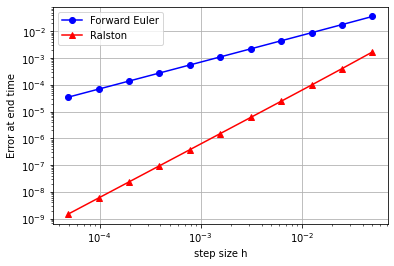

In [32]:
from matplotlib import pyplot as plt
plt.loglog(res[:,0],res[:,1],'bo-',label="Forward Euler")
plt.loglog(res[:,0],res[:,4],'r^-',label="Ralston")
plt.legend()
plt.grid(True)
plt.xlabel("step size h")
plt.ylabel("Error at end time")
plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document

 The Figure clearly shows the advantage of the method from Ralston's Method for a given step size. This is expected from a method that converges quadratically over a method with convergence order $1$.  For all step sizes the Ralston method outperforms the forward Euler method, which indicates that the constant in the error estimate of the Ralston method is not significantly higher compared to the constant in the estimate for the forward Euler method.

Finally, we compare the efficiency of the two methods.Each step of the Euler method __requires a single evaluation__ of the right hand side function $f$ in each step while the Ralston's Method __requires two evaluations__. Therefore, the computational cost of the method from Ralston's Method  measured by the number of evaluations of $f$ to simulate up to a fixed time $T$ will be __twice the cost__ of the forward Euler method. This measure is used on the $x$ axis in the final Figure showing the error for a given computational cost.

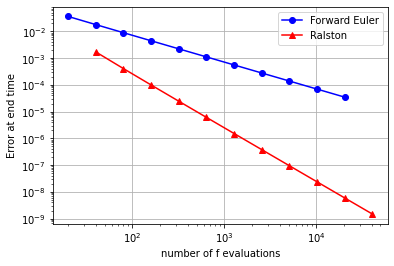

In [33]:
plt.loglog(T/res[:,0],res[:,1],'bo-',label="Forward Euler")
plt.loglog(2*T/res[:,0],res[:,4],'r^-',label="Ralston")
plt.legend()
plt.grid(True)
plt.xlabel("number of f evaluations")
plt.ylabel("Error at end time")
plt.savefig("Q2_compareEff.pdf", format="pdf", bbox_inches="tight")

Clearly __for this problem__ the method Ralston's Method outperforms the Forward
Euler method even for large time steps. For example to achieve an error of
$10^{-3}$ at the final time $T=10$ Ralston's Method requires an order
of magnitude less evaluations of $f  then the Forward Euler method. The
gap greatly increases if smaller errors are required.
